##### Copyright 2020 The TensorFlow Probability Authors.


In [0]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP, backed by Jax

Jax-backed TFP is a work in progress, but many distributions and bijectors are currently working! How do you use the alternative backend?

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/discussion/examples/TFP_and_Jax.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/discussion/examples/TFP_and_Jax.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Importing

In [1]:
# Importing the TFP with Jax backend
!pip3 install -q 'tfp-nightly[jax]' tf-nightly-cpu  # We (currently) still require TF, but TF's smaller CPU build will work.
import tensorflow_probability as tfp
tfp = tfp.experimental.substrates.jax
tf = tfp.tf2jax

# Standard TFP Imports
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

# Jax imports
import jax
import jax.numpy as np
from jax import random

# Other imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

TensorFlow 2.x selected.
     |████████████████████████████████| 3.5MB 4.9MB/s 
     |████████████████████████████████| 144.6MB 88kB/s 
     |████████████████████████████████| 2.9MB 56.8MB/s 
     |████████████████████████████████| 2.8MB 50.5MB/s 
     |████████████████████████████████| 460kB 53.9MB/s 
     |████████████████████████████████| 778kB 44.7MB/s 
ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.


## TF Interface to Jax

We've reimplemented the TF API, but with Jax functions instead of TF functions and DeviceArrays instead of TF Tensors.

In [2]:
tf.ones(5)

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([1., 1., 1., 1., 1.], dtype=float32)

In [3]:
tf.matmul(tf.ones([1, 2]), tf.ones([2, 4]))

DeviceArray([[2., 2., 2., 2.]], dtype=float32)

### Some differences:

Shapes are tuples, not TensorShapes

In [4]:
tf.ones(5).shape

(5,)

Randomness is stateless, like in Jax and requires Jax `PRNGKey`s to operate.

In [6]:
tf.random.stateless_uniform([1, 2], seed=random.PRNGKey(0))

DeviceArray([[0.21629536, 0.8041241 ]], dtype=float32)

Placeholders don't exist.


In [7]:
tf.compat.v1.placeholder_with_default(tf.ones(5), (5,))

DeviceArray([1., 1., 1., 1., 1.], dtype=float32)

## Math libraries

TFP's math libraries are now largely working, i.e. `tfp.math`

## Bijectors

Most bijectors have tests passing!

### Unary bijectors

In [9]:
bij = tfb.Shift(1.)(tfb.Scale(3.))
print(bij.forward(np.ones(5)))
print(bij.inverse(np.ones(5)))

[4. 4. 4. 4. 4.]
[0. 0. 0. 0. 0.]


### Meta bijectors

In [10]:
b = tfb.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=None)
print(b.forward(x=[0., 0., 0.]))
print(b.inverse(y=[[1., 0], [.5, 2]]))

[[1. 0.]
 [0. 1.]]
[0.6931472 0.5       0.       ]


In [11]:
b = tfb.Chain([tfb.Exp(), tfb.Softplus()])
# or: 
# b = tfb.Exp()(tfb.Softplus())
print(b.forward(-np.ones(5)))

[1.3678794 1.3678794 1.3678794 1.3678794 1.3678794]


### MCMC coming soon

We are migrating TFP's random samplers to be internally-stateless, then will update MCMC to support JAX.

### Some don't work yet
* For example: FFJORD, MAF (WIP), Real NVP

## Distributions

When sampling, we need to pass in a `seed`.

In [12]:
dist = tfd.Normal(loc=0., scale=1.)
print(dist.sample(seed=random.PRNGKey(0)))

-0.20584235


Jax distributions obey the same batching semantics as their TensorFlow counterparts.

In [13]:
dist =  tfd.Normal(np.zeros(5), np.ones(5))
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

dist =  tfd.Independent(tfd.Normal(np.zeros(5), np.ones(5)), 1)
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

(10, 2, 5)
(10, 2)


Most meta distributions are working!

In [14]:
dist = tfd.TransformedDistribution(
    tfd.MultivariateNormalDiag(tf.zeros(5), tf.ones(5)),
    tfb.Exp())
# or:
# dist = tfb.Exp()(tfd.MultivariateNormalDiag(tf.zeros(5), tf.ones(5)))
s = dist.sample(sample_shape=2, seed=random.PRNGKey(0))
print(s)
print(dist.log_prob(s).shape)

[[0.68927777 1.3024291  0.83316153 0.47863364 0.6438408 ]
 [0.85886437 0.5110164  0.55384845 2.0785878  1.7635037 ]]
(2,)


Gaussian processes and PSD kernels also work.

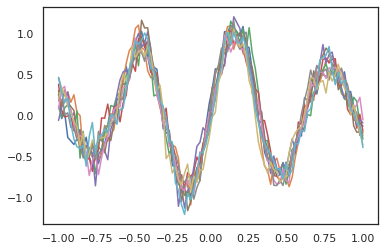

In [16]:
k1, k2, k3 = random.split(random.PRNGKey(0), 3)
observation_noise_variance = 0.01
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)
observation_index_points = tf.random.stateless_uniform(
    [50], minval=-1.,maxval= 1., seed=k1)[..., np.newaxis]
observations = f(observation_index_points) + tfd.Normal(loc=0., scale=np.sqrt(observation_noise_variance)).sample(seed=k2)

index_points = np.linspace(-1., 1., 100)[..., np.newaxis]

kernel = tfpk.ExponentiatedQuadratic(length_scale=0.1)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10, seed=k3)
for i in range(10):
  plt.plot(index_points, samples[i])
plt.show()

## Works in progress:

* Making all bijector/distribution tests pass (at around 90% now)
* Making bijectors/distributions convertible to/from Pytrees
* MCMC (and a push for stateless sampling at large in TFP)